# Sample Solution: Random Forest

In [1]:
# make sure  numpy, scipy, pandas, sklearn are installed, otherwise run
# pip install numpy scipy pandas scikit-learn
import numpy as np
import pandas as pd
from scipy import io
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data
raw_data = './data/raw/tox21/'
y_tr = pd.read_csv(raw_data+'tox21_labels_train.csv.gz', index_col=0, compression="gzip")
y_te = pd.read_csv(raw_data+'tox21_labels_test.csv.gz', index_col=0, compression="gzip")
x_tr_dense = pd.read_csv(raw_data+'tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
x_te_dense = pd.read_csv(raw_data+'tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
x_tr_sparse = io.mmread(raw_data+'tox21_sparse_train.mtx.gz').tocsc()
x_te_sparse = io.mmread(raw_data+'tox21_sparse_test.mtx.gz').tocsc()

In [3]:
# filter out very sparse features
sparse_col_idx = ((x_tr_sparse > 0).mean(0) > 0.05).A.ravel()
x_tr = np.hstack([x_tr_dense, x_tr_sparse[:, sparse_col_idx].A])
x_te = np.hstack([x_te_dense, x_te_sparse[:, sparse_col_idx].A])

## I'm only looking at the first target in this notebook.

In [4]:
# Build a random forest model for all twelve assays
for target in y_tr.columns[:1]:
    rows_tr = np.isfinite(y_tr[target]).values
    rows_te = np.isfinite(y_te[target]).values
    rf = RandomForestClassifier(n_estimators=100,  n_jobs=4)
    rf.fit(x_tr[rows_tr], y_tr[target][rows_tr])
    p_te = rf.predict_proba(x_te[rows_te])
    auc_te = roc_auc_score(y_te[target][rows_te], p_te[:, 1])
    print("%15s: %3.5f" % (target, auc_te))

         NR.AhR: 0.89966


In [42]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [43]:
y_testing=y_te[target][~np.isnan(y_te[target])]
y_hat_testing=rf.predict(x_te[rows_te])
print(np.array([['TN','FP'],['FN','TP']]))
print(confusion_matrix(y_testing,y_hat_testing))
print('f1: {0:0.5f}'.format(f1_score(y_testing,y_hat_testing)))
print('recall: {0:0.5f}'.format(recall_score(y_testing,y_hat_testing)))
print('precision: {0:0.5f}'.format(precision_score(y_testing,y_hat_testing)))
print('accuracy: {0:0.5f}'.format(accuracy_score(y_testing,y_hat_testing)))

[['TN' 'FP']
 ['FN' 'TP']]
[[529   8]
 [ 49  24]]
f1: 0.45714
recall: 0.32877
precision: 0.75000
accuracy: 0.90656


# Precision-Recall Curve as an Alternative Metric
Note: ROC curves can be misleading for strongly imbalanced data sets.<sup>[1](https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/), [2](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/), [3](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics), [4](https://stats.stackexchange.com/questions/90779/area-under-the-roc-curve-or-area-under-the-pr-curve-for-imbalanced-data)</sup>

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
%matplotlib inline

In [31]:
average_precision=average_precision_score(y_te[target][rows_te],p_te[:, 1])
print('Precision-Recall Curve "Average Precision": %0.4f' %average_precision)

Precision-Recall Curve "Average Precision": 0.5897


Max F1: 0.56954, threshold prob: 0.36000
Max F1 Precision: 0.55128, Recall: 0.58904


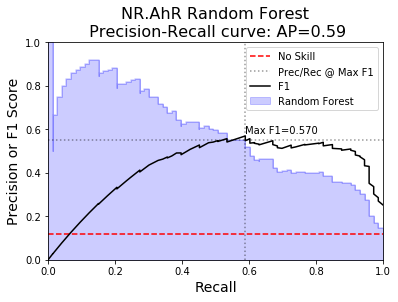

In [76]:
testy=y_te[target][rows_te]
precision, recall, thresholds = precision_recall_curve(testy,p_te[:, 1])
no_skill = len(testy[testy==1]) / len(testy)
f1 = 2*precision*recall/(precision+recall)
m_idx = np.argmax(f1)
m_thresh = thresholds[m_idx]
print('Max F1: %0.5f, threshold prob: %0.5f' % (f1[m_idx], m_thresh))
print('Max F1 Precision: %0.5f, Recall: %0.5f' % (precision[m_idx],recall[m_idx]))
fig = plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b',\
                 label='Random Forest')
plt.plot([0, 1], [no_skill, no_skill], color='r', linestyle='--', label='No Skill')
plt.plot([0, 1], [precision[m_idx],precision[m_idx]], color='k', alpha=0.4, linestyle=':')
plt.plot([recall[m_idx],recall[m_idx]],[0, 1], color='k', alpha=0.4,linestyle=':',\
         label='Prec/Rec @ Max F1')
plt.text(recall[m_idx], f1[m_idx]+0.01, 'Max F1={0:0.3f}'.format(f1[m_idx]))
plt.plot(recall,f1,color='k',label='F1')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision or F1 Score', fontsize=14)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend()
title=target+' Random Forest\n Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision)
plt.title(title, fontsize=16);
fig.savefig('./reports/figures/'+target+'_RandomForest_PrecisionRecallCurve.svg',\
            format='svg', dpi=1200, transparent=True, bbox_inches = "tight");

Source for the following function:
>Kevin Arvai, [Fine tuning a classifier in scikit-learn](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65), Towards Data Science Jan 18, 2018.

This was a helpful article that used a similar approach as I'm using here to optimize a classifier function.

In [20]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

# Modified Random Forest Model Metrics

In [44]:
y_hat_testing_adj=adjusted_classes(p_te[:, 1],0.36)
print('ROC_AUC: {0:0.5f}'.format(roc_auc_score(y_te[target][rows_te], p_te[:, 1]+0.14)))
print(np.array([['TN','FP'],['FN','TP']]))
print(confusion_matrix(y_testing,y_hat_testing_adj))
print('f1:{0:0.5f}'.format(f1_score(y_testing,y_hat_testing_adj)))
print('recall:{0:0.5f}'.format(recall_score(y_testing,y_hat_testing_adj)))
print('precision:{0:0.5f}'.format(precision_score(y_testing,y_hat_testing_adj)))
print('accuracy: {0:0.5f}'.format(accuracy_score(y_testing,y_hat_testing_adj)))

ROC_AUC: 0.89966
[['TN' 'FP']
 ['FN' 'TP']]
[[502  35]
 [ 30  43]]
f1:0.56954
recall:0.58904
precision:0.55128
accuracy: 0.89344


This result gives nearly twice the TP's and higher recall at the expense of more FP's!  Recall could be improved even further with minimally more FP's by further tuning the prediction threshold.